In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, cross_val_score, KFold
import seaborn as sns
import sys
from sklearn.svm import SVC
import statistics
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Defining function train_model

In [25]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = SVC(kernel='linear', random_state=42, probability=True)
    scoring = {
        'recall0': make_scorer(recall_score, average = None, labels = ['Non']),
        'recall1': make_scorer(recall_score, average = None, labels = ['NPF']),
        'recall2': make_scorer(recall_score, average = None, labels = ['undefined']),
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr'),
        'f1_score': make_scorer(f1_score, average='weighted')
        }
    param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': [1, 0.1, 0.01, 0.001], 
    'kernel': ['linear', 'rbf']
    }

    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train)
    kFold = KFold(n_splits=10, shuffle=True, random_state=42)
    results = cross_validate(estimator=model, X=X, y=y, cv=kFold, scoring=scoring)
    predictions=best_model.predict(X_test)
    return results, predictions, best_model, y_test, X_test

# Main code

In [26]:
#Read dataset
df = pd.read_csv(r'output_combined.csv')
#Prep the dataset
df = df.dropna()
df = df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.dayofyear
df = df.drop(df.index[-1])
# replacement_dict = {'non':0, 'NPF':1, 'undefined':2}
# df['day.type'] = df['day.type'].replace(replacement_dict)
df_orig = df

# Iteration 1

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 214, in wrapper
    return func(*args, **kwar

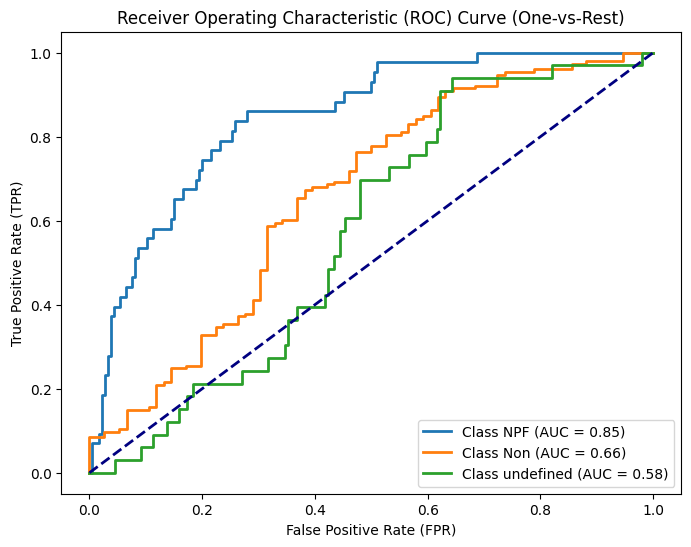

In [27]:
#Split dataset
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4", "NH4", "SO2"]].copy()
df = df_selected
X = df.drop(columns = 'day.type')
y = df['day.type']
#Unpack results
results, predictions, model, y_test, X_test = train_model(X=X, y=y)

#Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_roc_auc = statistics.mean(results.get('test_roc_auc', [None]))
average_f1 = statistics.mean(results.get('test_f1_score', [None]))
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_recall0 = statistics.mean(results.get('test_recall0', [None]))
average_recall1 = statistics.mean(results.get('test_recall1', [None]))
average_recall2 = statistics.mean(results.get('test_recall2', [None]))

#Redirect stdput to file
with open('svm_tuned_combination_3.txt', 'w') as file:
    sys.stdout = file
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)

    print("Average Roc_auc score:", average_roc_auc)
    print("Average F1 score:", average_f1)

    print("Average non-NPF recall:", average_recall0)
    print("Average NPF recall:", average_recall1)
    print("Average Undefined recall:", average_recall2)

    # Reset stdout back to the console
    sys.stdout = sys.__stdout__
    
# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('svm_ROC_combination_3.png', dpi=300)

# Iteration 2

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 214, in wrapper
    return func(*args, **kwar

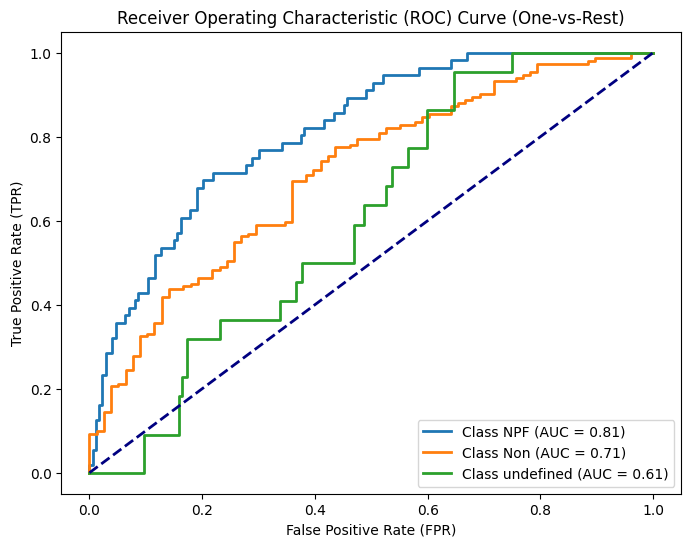

In [28]:
#Split dataset
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type", "NH3", "SO4"]].copy()
df = df_selected
X = df.drop(columns = 'day.type')
y = df['day.type']
#Unpack results
results, predictions, model, y_test, X_test = train_model(X=X, y=y)

#Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_roc_auc = statistics.mean(results.get('test_roc_auc', [None]))
average_f1 = statistics.mean(results.get('test_f1_score', [None]))
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_recall0 = statistics.mean(results.get('test_recall0', [None]))
average_recall1 = statistics.mean(results.get('test_recall1', [None]))
average_recall2 = statistics.mean(results.get('test_recall2', [None]))

#Redirect stdput to file
with open('svm_tuned_combination_2.txt', 'w') as file:
    sys.stdout = file
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)

    print("Average Roc_auc score:", average_roc_auc)
    print("Average F1 score:", average_f1)

    print("Average non-NPF recall:", average_recall0)
    print("Average NPF recall:", average_recall1)
    print("Average Undefined recall:", average_recall2)

    # Reset stdout back to the console
    sys.stdout = sys.__stdout__
    
# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('svm_tuned_ROC_combination_2.png', dpi=300)

# Iteration 3

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 214, in wrapper
    return func(*args, **kwar

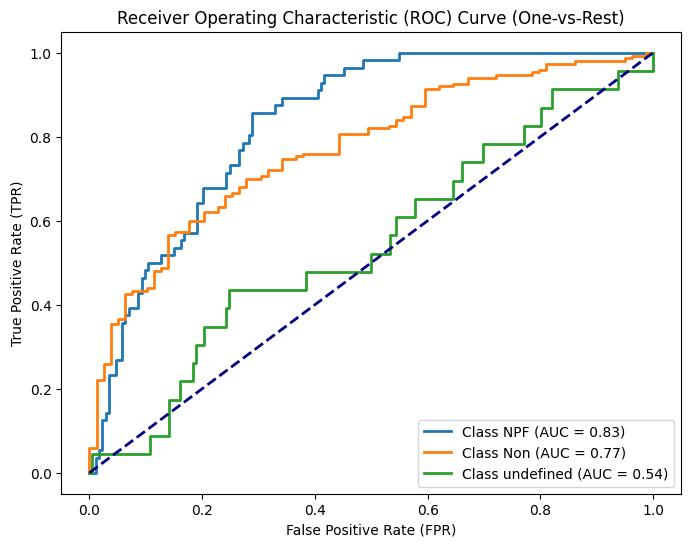

In [29]:
#Split dataset
df_selected = df_orig[["date", "pressure", "RH", "temperature", "SWD", "day.type"]].copy()
df = df_selected
X = df.drop(columns = 'day.type')
y = df['day.type']
#Unpack results
results, predictions, model, y_test, X_test = train_model(X=X, y=y)

#Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_roc_auc = statistics.mean(results.get('test_roc_auc', [None]))
average_f1 = statistics.mean(results.get('test_f1_score', [None]))
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_recall0 = statistics.mean(results.get('test_recall0', [None]))
average_recall1 = statistics.mean(results.get('test_recall1', [None]))
average_recall2 = statistics.mean(results.get('test_recall2', [None]))

#Redirect stdput to file
with open('svm_tuned_combination_1.txt', 'w') as file:
    sys.stdout = file
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)

    print("Average Roc_auc score:", average_roc_auc)
    print("Average F1 score:", average_f1)

    print("Average non-NPF recall:", average_recall0)
    print("Average NPF recall:", average_recall1)
    print("Average Undefined recall:", average_recall2)

    # Reset stdout back to the console
    sys.stdout = sys.__stdout__
    
# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('svm_tuned_ROC_combination_1.png', dpi=300)

# iteration 4

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 136, in __call__
    score = scorer._score(
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 214, in wrapper
    return func(*args, **kwar

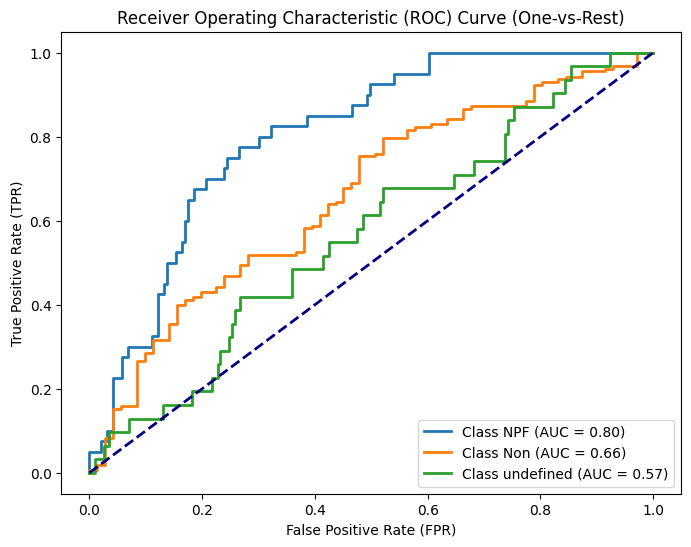

In [30]:
#Split dataset
df_selected = df_orig[["pressure", "RH", "temperature", "SWD", "day.type"]].copy()
df = df_selected
X = df.drop(columns = 'day.type')
y = df['day.type']
#Unpack results
results, predictions, model, y_test, X_test = train_model(X=X, y=y)

#Calculate average metrics
average_accuracy = statistics.mean(results['test_accuracy'])
average_precision = statistics.mean(results['test_precision'])
average_recall = statistics.mean(results['test_recall'])
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_roc_auc = statistics.mean(results.get('test_roc_auc', [None]))
average_f1 = statistics.mean(results.get('test_f1_score', [None]))
stdev_accuracy = statistics.stdev(results['test_accuracy'])
average_recall0 = statistics.mean(results.get('test_recall0', [None]))
average_recall1 = statistics.mean(results.get('test_recall1', [None]))
average_recall2 = statistics.mean(results.get('test_recall2', [None]))

#Redirect stdput to file
with open('svm_tuned_combination_0.txt', 'w') as file:
    sys.stdout = file
    print("Accuracies: ", results['test_accuracy'])
    print("Average Accuracy:", average_accuracy)
    print("Stdev Accuracy: ", stdev_accuracy)
    print("Average Precision:", average_precision)
    print("Average Recall:", average_recall)

    print("Average Roc_auc score:", average_roc_auc)
    print("Average F1 score:", average_f1)

    print("Average non-NPF recall:", average_recall0)
    print("Average NPF recall:", average_recall1)
    print("Average Undefined recall:", average_recall2)

    # Reset stdout back to the console
    sys.stdout = sys.__stdout__
    
# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('svm_tuned_ROC_combination_0.png', dpi=300)